In [1]:
# import the necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import cv2
import os


## Modules to check the performance of the code
from time import process_time 
# !pip install memory_profiler ## When running from Google Colab
# import memory_profiler as mem_profile
# print('Memory (Before): {}Mb'.format(mem_profile.memory_usage()))


## Importing the necessary TesnorFLow modules modules
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')

from tensorflow import keras
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score ## form calcualting the r2 score
from sklearn.utils import shuffle
from tensorflow import keras as k
from keras_preprocessing.image import ImageDataGenerator

## Trasfer Learning Models
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1 
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5 
from tensorflow.keras.applications import EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import ResNet50,ResNet50V2

In [2]:
############ Please provide the same path to the code directory if using Colab################

# Path_gdrive= '/content/drive/MyDrive/DPNNet-RT/' ## Comment out this line if using local computer

## Importing the Modules from Modules_DPNNet
import sys
try: ## tries to find the modules in the local directory first
  current_directory = os.getcwd()
  path = current_directory + '/' # For local computer 
#   path = '' # For local computer  
  sys.path.append(path+'MODULES_DPNNeT')
  import data_processing_RT as dp
  import deep_models as dm
  import other_cnns as ocn

########### Folders to save the processed data, files and figures when using Local computer ##############
  output_folder_list = ['data_folder','figures','saved_model']
  for file in output_folder_list:
    try:
        os.makedirs(file)
    except OSError:
        print ("Creation of the directory %s failed/ not needed as it already exit" % file)
    else:
        print ("Successfully created the directory %s" % file)
  
except ModuleNotFoundError:
  
  # #For Colab use:
  # #Point to the path containing the modules in the above section
  #(data folder are a directory above the directory containing the notebook)
  try:
    path = Path_gdrive
    print(path)
    sys.path.append(path+'MODULES_DPNNeT')
    import data_processing_RT as dp
    import deep_models as dm
    import other_cnns as ocn

    ########### Folders to save the processed data, files and figures when using GDRIVE ##############
    import os
    os.chdir(path)
    print("Creating the folders")
    !mkdir -p data_folder
    !mkdir -p figures ## to save the figures
    !mkdir -p figures_paper
    !mkdir -p saved_model
  except ModuleNotFoundError:
    print("The path to the modules is incorrect-- Provide current path")

print("[INFO] Modules imported")



We are currently using the Modules_DPCNet-RT
Creation of the directory data_folder failed/ not needed as it already exit
Creation of the directory figures failed/ not needed as it already exit
Creation of the directory saved_model failed/ not needed as it already exit
[INFO] Modules imported


# Model Selections and Hyperparameters

In [3]:

#### Desired Image resoltuion  and Batch Size #####
X_res = Y_res = 256

Cutoff_resolution = 600
## Select the kind of Traning ## Both can be selected as well
REG = True #True  ## When choosing regression
CLA = False #False #False #True  ## When Choosing Clasiffication


## Select the Network type

# NETWORK = "Vanilla" ## Cannot be uses at the moment
# NETWORK = "ALEXNET"
# NETWORK = "VGG"
# NETWORK = "RESNET50"

                                ########## When using Trasnfer Learning ######################
NETWORK = "TL"
transfer_model=ResNet50
# transfer_model=EfficientNetB3

## Hyper-Parameter to define
batch_size = 32 ## 20 was for regression ## the best was for 200 last run

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.2, patience=20, verbose=1, mode='min',restore_best_weights=True)


In [4]:
test = pd.read_csv("data_folder/test_dataset.csv")
train = pd.read_csv("data_folder/train_dataset.csv")
val = pd.read_csv("data_folder/val_dataset.csv")
## Generate the Normalized data
normed_train_data, normed_test_data, normed_val_data, train_labels, test_labels, val_labels, Y_train, Y_val, Y_test = dp.process_the_disk_attributes(train, test, val, path, multi_label=True)

import time
start = time.time()

if CLA == True:

        y_col = ['Planet_Count']

elif REG == True:
        y_col=["Planet_Mass1",'Planet_Mass2','Planet_Mass3']

        
        ###### Generate the training and the test images######
if X_res >= Cutoff_resolution:
    
    def custom_augmentation(np_tensor):

        '''
        This function is used to crop the images when those are loaded using the 
        ImageDataGenerator Keras function. This custom augmentation function only
        works for three different res as given below. For other resolutions the 
        image needs to the cropped appropiately.

        '''

        # # # dimensions for cropping the image
        if X_res == 64:
          top,left,bottom,right = 8,11,55,48
        if X_res == 128:
          top,left,bottom,right = 20,25,110,90 
        if X_res == 256:          
          top,left,bottom,right = 40,50,220,180          
        if X_res == 512:
          top,left,bottom,right = 60,90,450,380          
                
        image = np.squeeze(np_tensor) 
        crop_image = image[top:bottom, left:right]
        crop_image = cv2.resize(crop_image, (X_res, Y_res)) 
        crop_image = k.preprocessing.image.img_to_array(crop_image)
        return crop_image

#     datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,samplewise_center=True, samplewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
#     datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,featurewise_center=True,featurewise_std_normalization=True,rescale=1./255.,validation_split=0.15)
    if transfer_model == ResNet50:
        datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,zca_epsilon = 100, zca_whitening=True,rescale=1./255.,validation_split=0.15)
    else:
        datagen= ImageDataGenerator(preprocessing_function=custom_augmentation,validation_split=0.15)


    #### TESTING GENERATOR #####
    test_datagen= k.preprocessing.image.ImageDataGenerator(preprocessing_function=custom_augmentation,zca_epsilon = 100, zca_whitening = True,rescale=1./255.)
    test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="image_path",
    y_col=y_col,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(X_res,Y_res))
    
    
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

 

else:
    print("Uploading directly to RAM as the image resolution is manageable")
    # trainImagesX = dp.load_disk_images(train, X_res, Y_res, Type = "Train")
    # valImagesX = dp.load_disk_images(val, X_res, Y_res, Type = "Val")
    testImagesX = dp.load_disk_images(test, X_res, Y_res, Type = "Test")



[INFO] preparing the normalized data training/testing split...
Droping the irrelevant columns 
INFO: considering multiple planets as output
[INFO] Done...
Uploading directly to RAM as the image resolution is manageable
[INFO] Loading images from Test data..


/home/sauddy3/ML-ENV1/lib/python3.8/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/sauddy3/ML-ENV1/lib/python3.8/site-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Test Images are loaded


## Checking the loaded test images

(256, 256, 3)


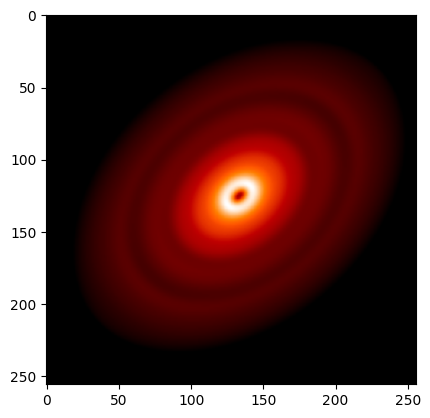

(256, 256, 3)


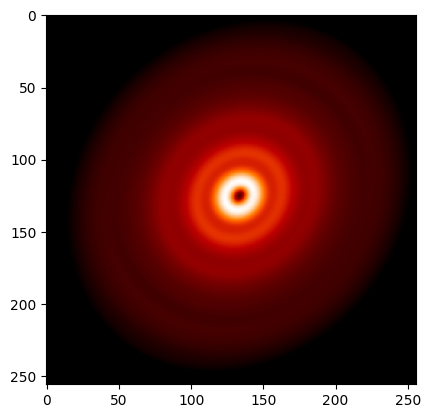

(256, 256, 3)


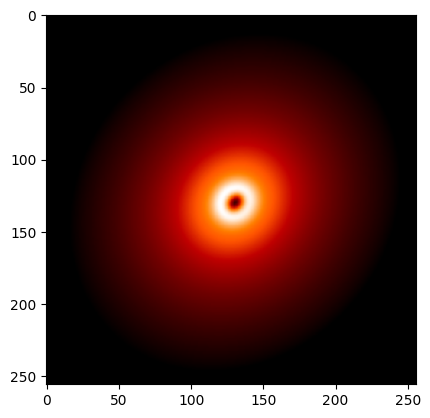

(256, 256, 3)


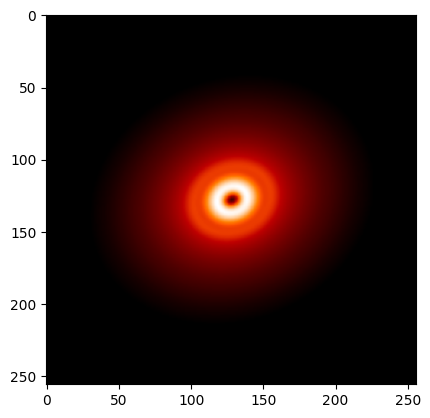

(256, 256, 3)


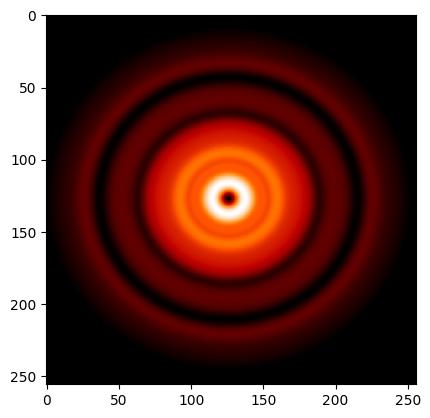

In [5]:
if X_res>= Cutoff_resolution:
    for _ in range(5):
        img, label = test_generator.next()
        print(img.shape)   #  (1,256,256,3)
        plt.imshow(img[0])
        plt.show()
else:
    for i in range(5):
        print(testImagesX[i].shape)   #  (1,256,256,3)
        plt.imshow(testImagesX[i])
        plt.show()


## Loading the Model

In [6]:
# Loading the model

if NETWORK == "TL":
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str( transfer_model.__name__)+'_'+str(X_res)+'_modelC')
        
    print("INFO:The Trained model {} at res {} is loaded ".format(NETWORK+'_'+str( transfer_model.__name__),str(X_res)))
else:
    if REG == True and CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
    elif REG == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelR')
    elif CLA == True:
        CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelC')



# CNN = tf.keras.models.load_model(path+'saved_model/'+NETWORK+'_'+str(X_res)+'_modelRC')
#Check its architecture
# CNN.summary()

2023-03-18 13:40:04.905277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-18 13:40:04.908211: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-18 13:40:04.913489: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cdr861.int.cedar.computecanada.ca): /proc/driver/nvidia/version does not exist
2023-03-18 13:40:04.976988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:The Trained model TL_ResNet50 at res 256 is loaded 


In [ ]:

if X_res >= Cutoff_resolution:

    test_generator.reset()
    pred_CNN=CNN.predict_generator(test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)
else:
    
    pred_CNN = CNN.predict(testImagesX)  
# pred_CNN[test_index]


80/99 [=======================>......] - ETA: 2:33

In [ ]:
test_index = 40 # 550  #550 ##210
# plt.imshow(testImagesX[test_iclass_mode)
if REG == True:
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))
elif CLA == True:
    print("The predicted prbability of the presence of planets are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],Y_test.iloc[test_index]))
    print("The predicted Values are {} and \nThe True values are \n{} ".format(pred_CNN[test_index],test_labels.iloc[test_index]))

# plt.imshow(testImagesX[test_index])
# test_labels.iloc[test_index]

In [ ]:
plt.style.use('classic')
plt.figure(figsize = (5,5))
# test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels.to_numpy().flatten(),pred_CNN.flatten(),s=15,marker='d',color='r')
score_CNN = r2_score(test_labels.to_numpy().flatten(),pred_CNN.flatten())
plt.text(20,880,r" r2 = {:.3f}".format(score_CNN), fontsize =14)
plt.xlabel(r'True values of planet mass($M_\oplus$)', fontsize=15)
plt.ylabel(r'Predicted planet mass($M_\oplus$)',fontsize=15)
plt.title("{} Prediction".format(NETWORK))
plt.axis('equal')
plt.axis('square')
plt.xlim(10,1000)
plt.ylim(10,1000)
# plt.yscale("log")
# plt.xscale('log')
# plt.xlim([0.6,plt.xlim()[1]])
# plt.ylim([0.6,plt.xlim()[1]])
_ = plt.plot([0, 1200], [0, 1200],linewidth=2)
plt.minorticks_on() 
plt.tight_layout()
plt.show()
# plt.savefig(path+'figures_paper/predicted_correlation_{}.pdf'.format(NETWORK),format='pdf',dpi=300)

# np.shape(pred_CNN.flatten())